Notebook to generate calibrated narrow band images from datacubes.

In [1]:
from astropy.io import fits
import spectrum
import numpy as np
#import pysao
from matplotlib import pyplot as plt
from astropy.wcs import WCS
#% matplotlib inline
from astropy.io import ascii
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter

In [150]:
def nb_image(ax, c, cal_interp, wlstart, wlend, vmin=0., vmax=2., sigma=1., A_pix = 0.5**2., ticks=[0,.5,1.,1.5,2.], CSUB=0,irange=[]):
    ww = c.grid()
    
    if irange == []:
        ii =  ww >= wlstart
        ii *= ww <= wlend
    else:
        ii =  ww >= ww[irange[0]]
        ii *= ww <= ww[irange[1]]
    
    wwcentral = (ww[ii][0] + ww[ii][-1] )/2.
    wwdelta = ww[ii][-1] - ww[ii][0]
    
    #collapse slice 
    NB = np.sum(c.data[ii], axis=0)
    
    if CSUB:
        cc1 = (ww >= (wlstart-wwdelta*CSUB)) * (ww < wlstart)
        cc2 = (ww > wlend) * (ww <= (wlend+wwdelta*CSUB))
        C   = (np.sum(c.data[cc1], axis=0) + np.sum(c.data[cc2], axis=0))/(2.*CSUB)
        NB = NB - C



    # calibrate

    calim = NB * cal_interp(wwcentral) / A_pix

    colormap = plt.get_cmap('ds9staircase')

    calim[calim == 0.] = np.nan
    colormap.set_bad(color='grey')

    im = gaussian_filter(calim, sigma)*1e18
    image = ax.imshow(im, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest', cmap=colormap)

    cbar = ax.figure.colorbar(image)
    plt.text(.67, .97, "wl$_{{cen}}$ = {:.1f} $\AA$\n$\Delta\lambda = {:.1f}\AA$"\
             .format(wwcentral, wwdelta), transform=ax.transAxes, color='white', va='top')
    cbar.set_label("10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$")
    cbar.set_ticks(ticks)
    
    xcoll = np.nansum(calim,axis=0)
    ycoll = np.nansum(calim,axis=1)
    xx = np.arange(calim.shape[1])
    yy = np.arange(calim.shape[0])
    ymin = np.nanmin( yy[ycoll > 0.] ) 
    ymax = np.nanmax( yy[ycoll > 0.] ) 
    xmin = np.nanmin( xx[xcoll > 0.] ) 
    xmax = np.nanmax( xx[xcoll > 0.] ) 
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

In [8]:
RUN_AS_NOTEBOOK = True

if RUN_AS_NOTEBOOK:
    %matplotlib inline

In [3]:
def register_ds9staircase():
    # register color map
    from matplotlib.cm import register_cmap, cmap_d

    colors = []
    for ii in range(1,6):
        kk = ii/5.
        colors.append( (kk*.3,kk*.3,kk*1)  )

    for ii in range(1,6):
        kk = ii/5.
        colors.append( (kk*.3,kk*1,kk*.3)  )
    for ii in range(1,6):
        kk = ii/5.
        colors.append( (kk*1,kk*.3,kk*.3)  )
    colors = np.array(colors)
    xx = np.arange(len(colors), dtype=float)
    xx = xx/xx.max()

    ds9staircase = {'red': lambda v : np.interp(v, xx, colors[:,0]),
               'green': lambda v : np.interp(v, xx, colors[:,1]),
               'blue': lambda v : np.interp(v, xx, colors[:,2])}


    # Register all other colormaps
    register_cmap('ds9staircase', data=ds9staircase)

register_ds9staircase()

In [4]:
def sky_to_px(fncube, ra, dec):
    h = fits.getheader(fncube)
    w = WCS(h)
    w = w.dropaxis(2)
    return  w.wcs_world2pix(ra,dec,0.)    

In [152]:
def show_nb_image(fncube, fncal, wlstart, wlend, vmin, vmax, sigma=1., A_pix = 0.5**2., \
                  figsize=[9,7], ax=None, ra=[], dec=[], x=[], y=[], ticks=[0,.5,1.,1.5,2.], \
                  marker='x', markersize=10, alpha=1., CSUB=0, irange=[]):
    c = spectrum.readSpectrum(fncube)
    hdu = c.hdu
    w = WCS(hdu.header)
    w = w.dropaxis(2)

    tcal = ascii.read(fncal, format="fixed_width")
    cal_interp = interp1d(tcal["wl[A]"], tcal["cal[erg/s/cm^2/A/cnt]"], kind='cubic', bounds_error=False)

    if ax == None:
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(111,projection=w)

    nb_image(ax, c, cal_interp, wlstart, wlend, vmin=vmin, vmax=vmax, sigma=sigma, A_pix = 0.5**2.,ticks=ticks, \
             CSUB=CSUB, irange=irange)
    
    if not ra == []:
        xx,yy = sky_to_px(fncube, ra, dec )
        ax.plot(xx,yy, markeredgewidth=2., marker=marker, markersize=markersize, markeredgecolor='w', alpha=alpha)
        
    if not x == []:
        ax.plot(x,y, markeredgewidth=2., marker=marker, markersize=markersize, markeredgecolor='w', alpha=alpha)

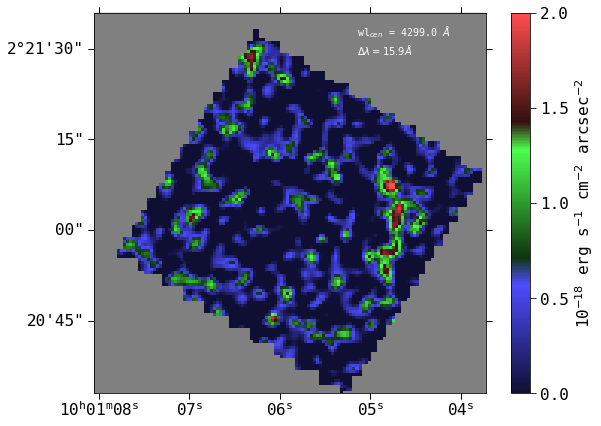

In [82]:
if RUN_AS_NOTEBOOK:
    field, ifu = "COSMOSC", "025"
    wlstart = 4289.08
    wlend = 4306.95
    
    if False:
        dwl = 20.
        wl  = 4298.01
        wlstart = wl-dwl/2.
        wlend   = wl+dwl/2.
    
    vmin=0.
    vmax=2.
    sigma=1.2
    CSUB = 3.
    A_pix = 0.5**2.
    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)
    %matplotlib inline
    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, A_pix = A_pix, CSUB=CSUB)

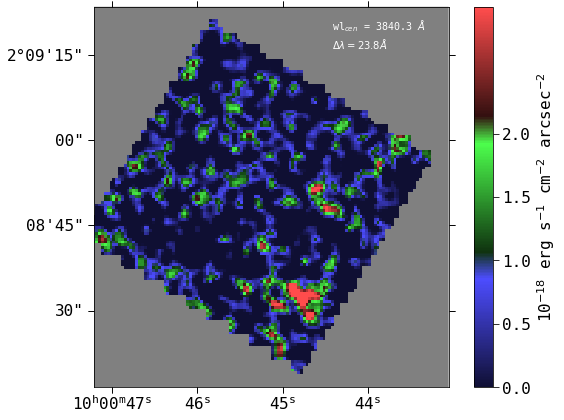

In [96]:
if RUN_AS_NOTEBOOK:
    field, ifu = "COSMOSA", "022"
    wlstart = 3840.61 - 49.65/4.
    wlend = 3840.61 + 49.65/4.
    vmin=0.
    vmax=3.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, A_pix = A_pix, CSUB=CSUB)

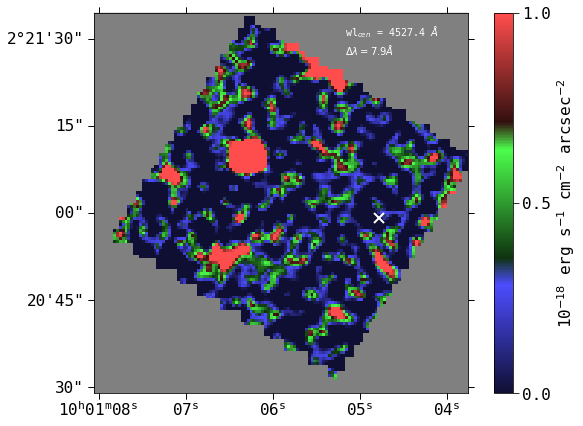

In [88]:
if RUN_AS_NOTEBOOK:
    field, ifu = "COSMOSC", "025"
    wlstart = 4527.65 - 5.
    wlend = 4527.65 + 5.
    vmin=0.
    vmax=1.
    CSUB = 0.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, ra = 150.269912, dec = 2.349743, CSUB=CSUB)


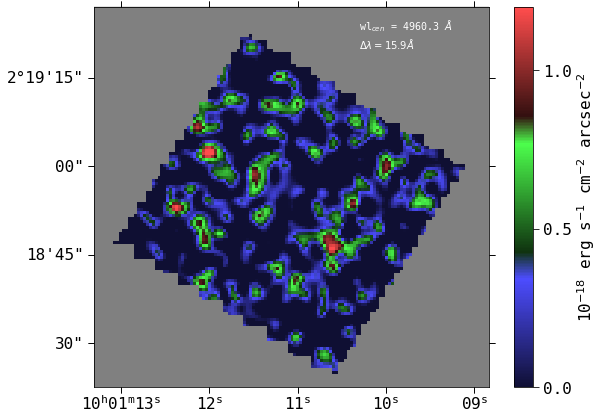

In [122]:
if RUN_AS_NOTEBOOK:
    field, ifu = "COSMOSD", "023"
    wlstart = 4960.3 - 8.
    wlend = 4960.3 + 8.
    vmax=1.2
    CSUB = 2.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.5
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)


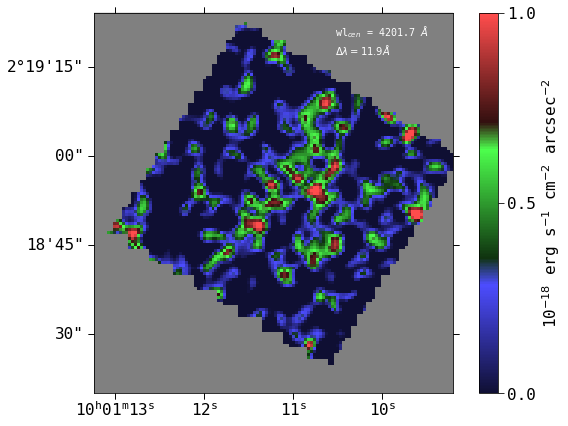

In [121]:
if RUN_AS_NOTEBOOK:
    field, ifu = "COSMOSD", "023"
    wlstart = 4201.7 - 7.5
    wlend = 4201.7 + 7.5
    vmin=0.
    vmax=1.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.5
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix,  CSUB=CSUB)


ValueError: zero-size array to reduction operation fmin which has no identity

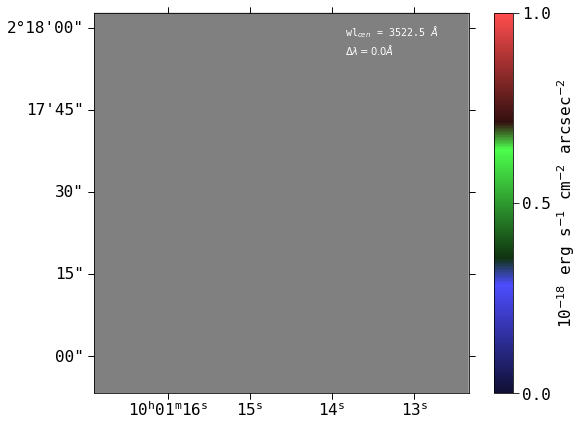

In [123]:
if RUN_AS_NOTEBOOK:
    field, ifu = "COSMOSD", "022"
    wlstart = 3522.54 - 1.
    wlend = 3522.54 + 1.
    vmin=0.
    vmax=1.
    CSUB = 0.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.5
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)


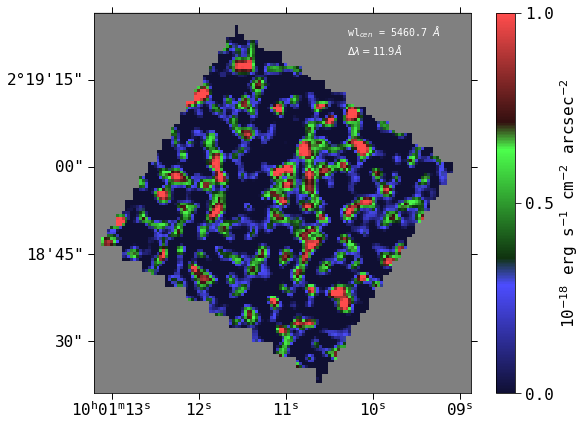

In [140]:
if RUN_AS_NOTEBOOK:
    field, ifu = "COSMOSD", "023"
    wlstart = 5460.7 - 7.5
    wlend = 5460.7 + 7.5
    vmin=0.
    vmax=1.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)


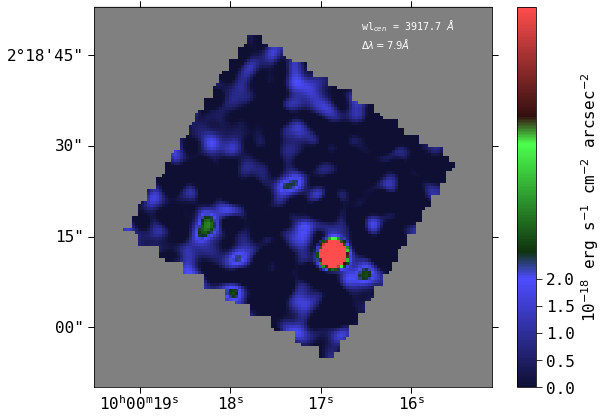

In [135]:
if RUN_AS_NOTEBOOK:
    field, ifu = "COSMOSD", "097"
    wlstart = 3917.7 - 5.
    wlend = 3917.7 + 5.
    vmin=0.
    vmax=7.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=2.
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)


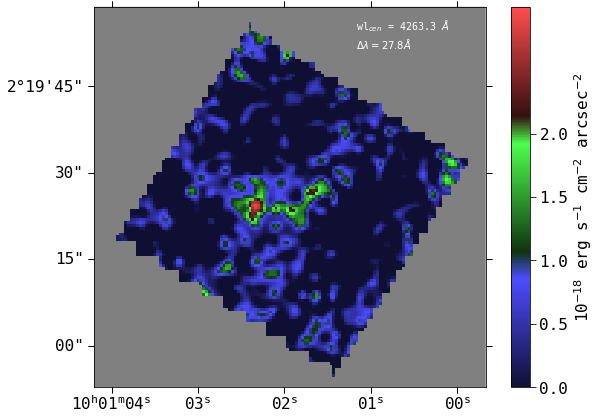

In [152]:
if RUN_AS_NOTEBOOK:
    field, ifu = "COSMOSD", "034"
    wlstart = 4247.4
    wlend = 4277.2
    vmin=0.
    vmax=3.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)


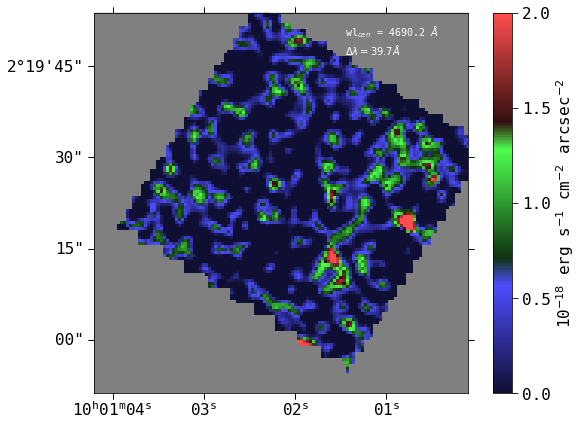

In [159]:
if RUN_AS_NOTEBOOK:
    field, ifu = "COSMOSD", "034"
    wlstart = 4670.
    wlend = 4712.
    vmin=0.
    vmax=2.
    CSUB = 5.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

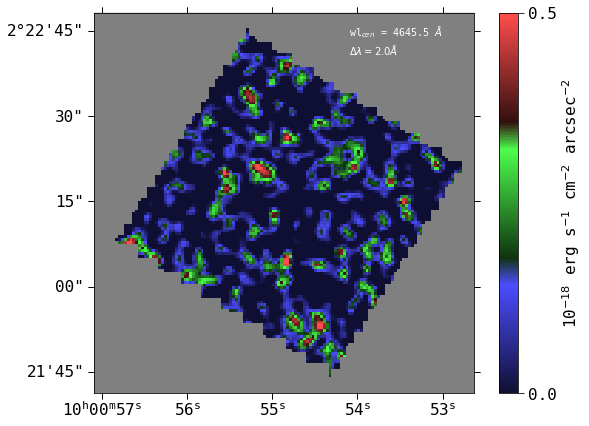

In [16]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "036"
    wlstart = 4642.56
    wlend = 4648.5
    vmin=0.
    vmax=.5
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

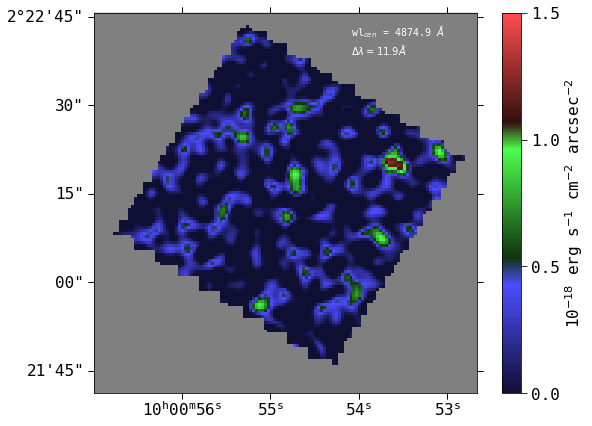

In [22]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "036"
    wlstart = 4866.96
    wlend = 4880.86
    vmin=0.
    vmax=1.5
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.5
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

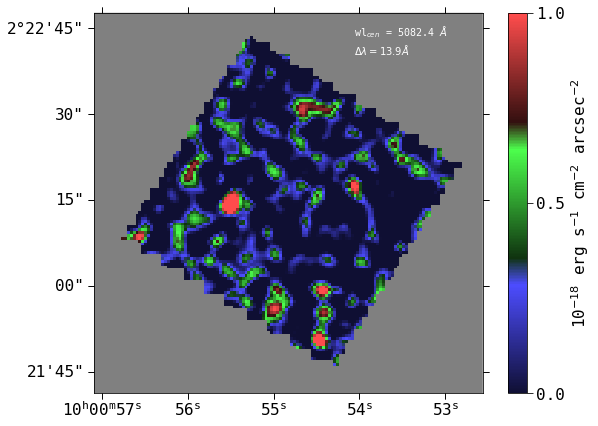

In [26]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "036"
    wlstart = 5073.5
    wlend = 5089.37
    vmin=0.
    vmax=1.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.5
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

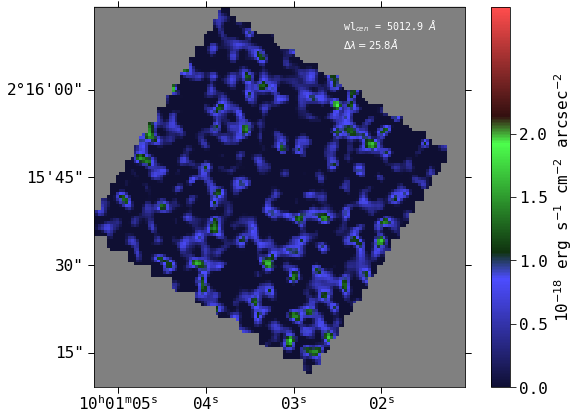

In [34]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "042"
    wlstart = 5000.0
    wlend = 5027.8
    vmin=0.
    vmax=3.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

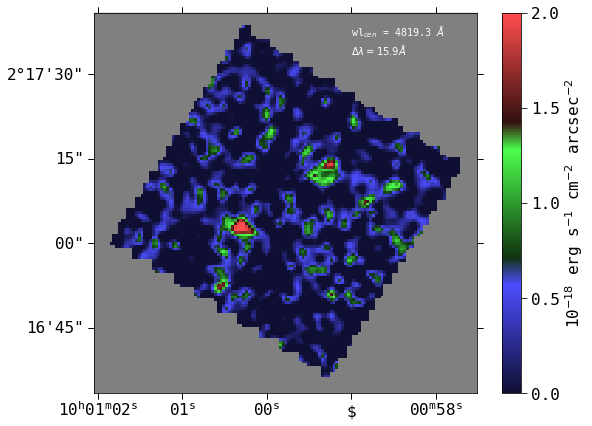

In [37]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "043"
    wlstart = 4809.37
    wlend = 4829.22
    vmin=0.
    vmax=2.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

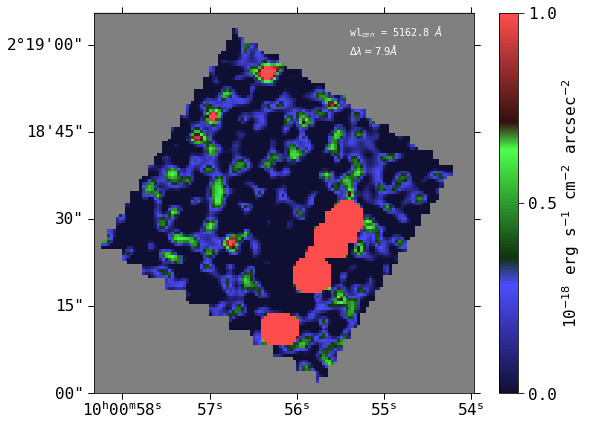

In [48]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "044"
    wlstart = 5156.9
    wlend = 5168.8
    vmin=0.
    vmax=1.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

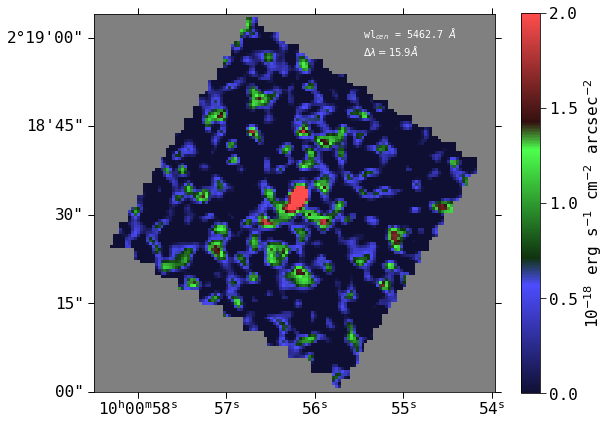

In [54]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "044"
    wlstart = 5452.8
    wlend = 5472.6
    vmin=0.
    vmax=2.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

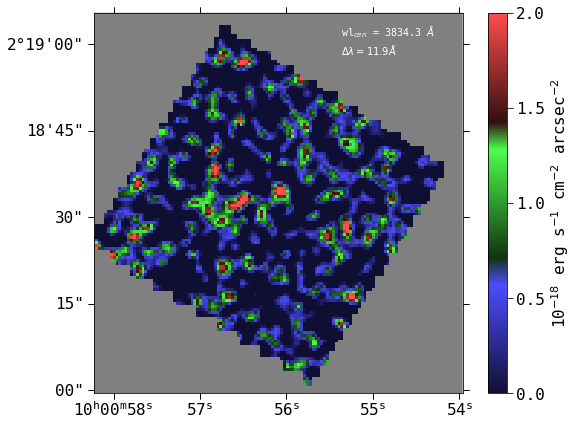

In [62]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "044"
    wlstart = 3826.38
    wlend = 3840.28
    vmin=0.
    vmax=2.
    CSUB = 1.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.1
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

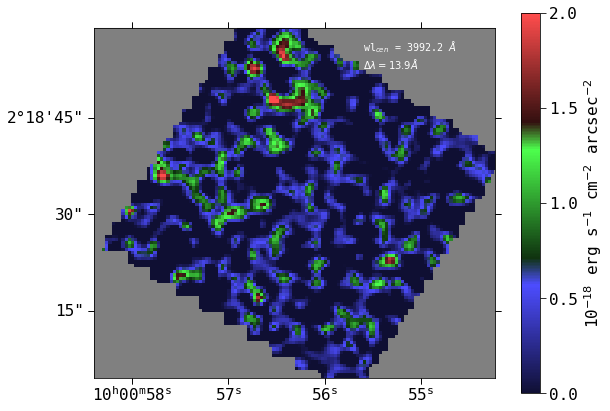

In [63]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "044"
    wlstart = 3985.24
    wlend = 4001.12
    vmin=0.
    vmax=2.
    CSUB = 1.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.1
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

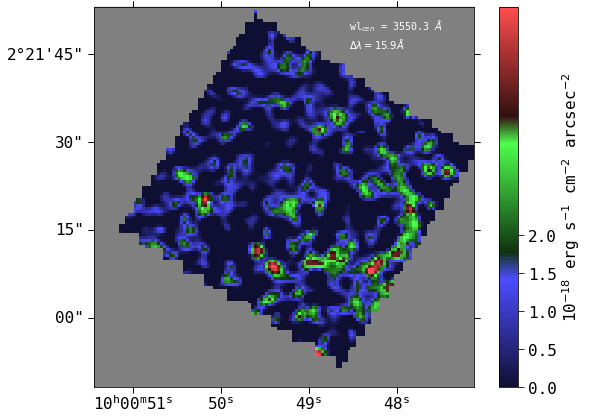

In [108]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "046"
    wlstart = 3542
    wlend = 3560.
    vmin=0.
    vmax=5.
    CSUB = 1.1

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)
    
    plt.ylim([0,130])
    plt.xlim([0,130])

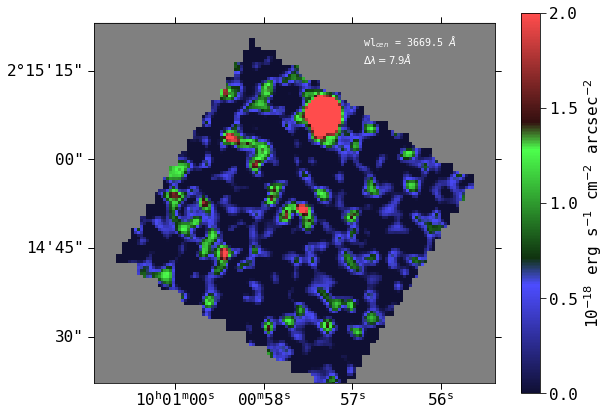

In [81]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "052"
    wlstart = 3665.5
    wlend = 3675.45
    vmin=0.
    vmax=2.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

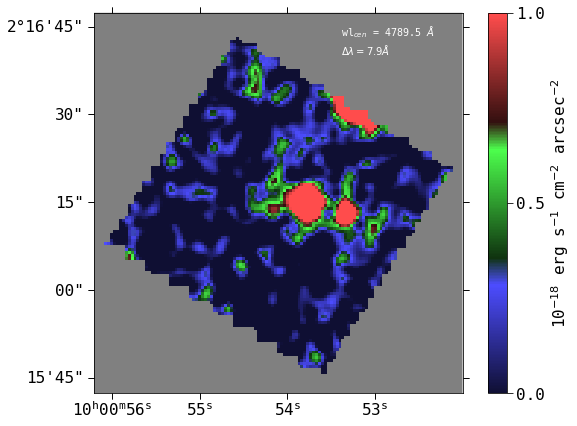

In [109]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "053"
    wlstart = 4785.
    wlend = 4795.
    vmin=0.
    vmax=1.
    CSUB = 4.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.5
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

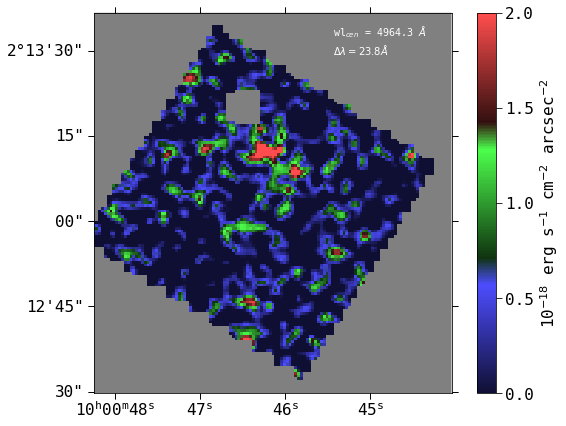

In [115]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "072"
    wlstart = 4952
    wlend = 4978
    vmin=0.
    vmax=2.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

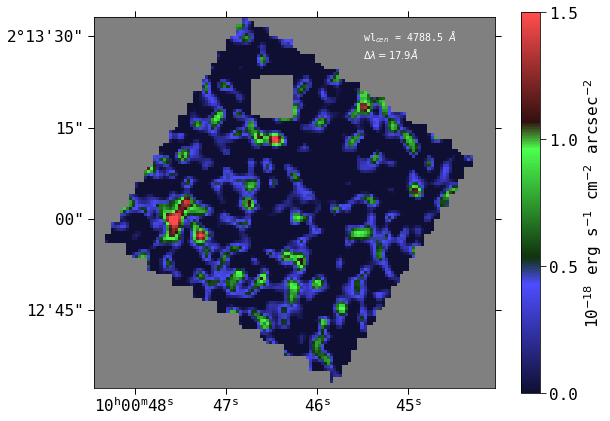

In [123]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "072"
    wlstart = 4779.
    wlend = 4799
    vmin=0.
    vmax=1.5
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

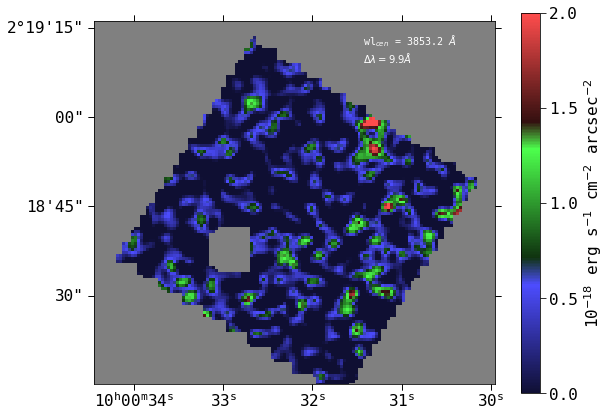

In [146]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "076"
    wlstart = 3848.
    wlend = 3860.
    vmin=0.
    vmax=2.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

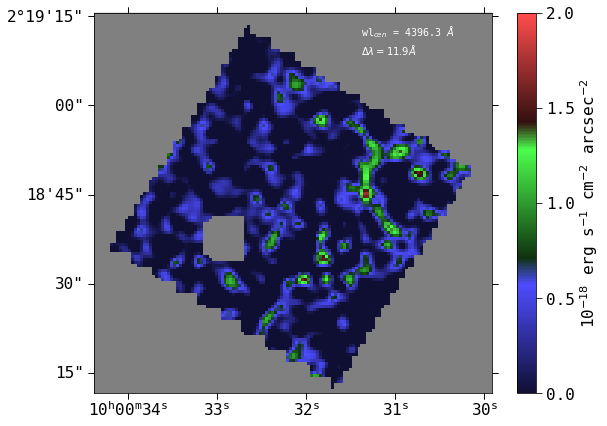

In [147]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "076"
    wlstart = 4390.3
    wlend = 4402.27
    vmin=0.
    vmax=2.
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.3
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB)

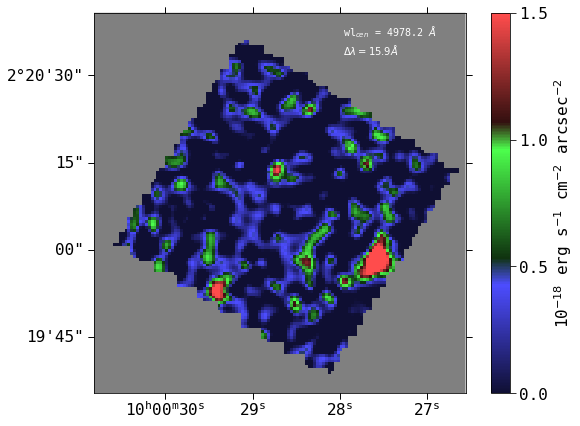

In [156]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "077"
    irange = [743,751]
    vmin=0.
    vmax=1.5
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.5
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB, irange=irange)

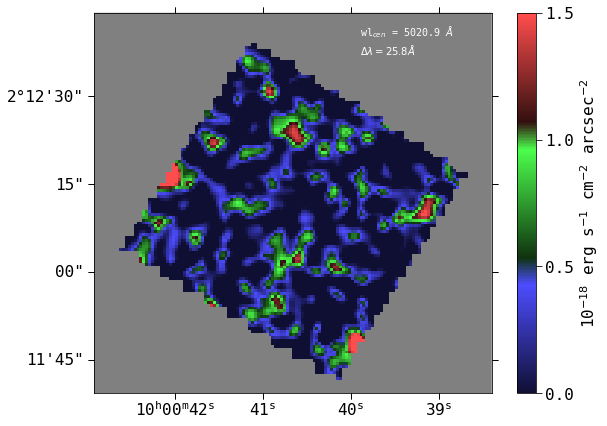

In [164]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "082"
    irange = [762,775]
    vmin=0.
    vmax=1.5
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.5
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB, irange=irange)

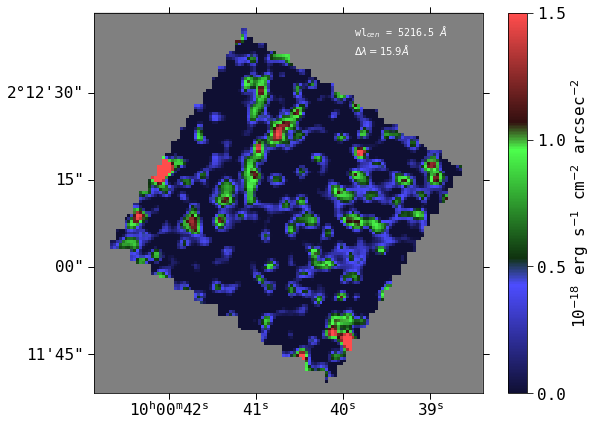

In [166]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "082"
    irange = [863,871]
    vmin=0.
    vmax=1.5
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB, irange=irange)

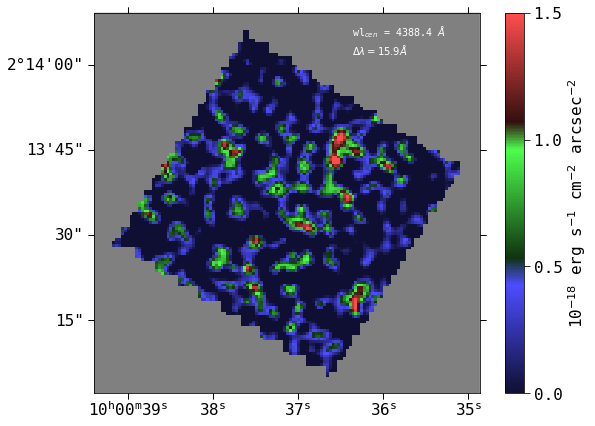

In [167]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "083"
    irange = [446,454]
    vmin=0.
    vmax=1.5
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.2
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB, irange=irange)

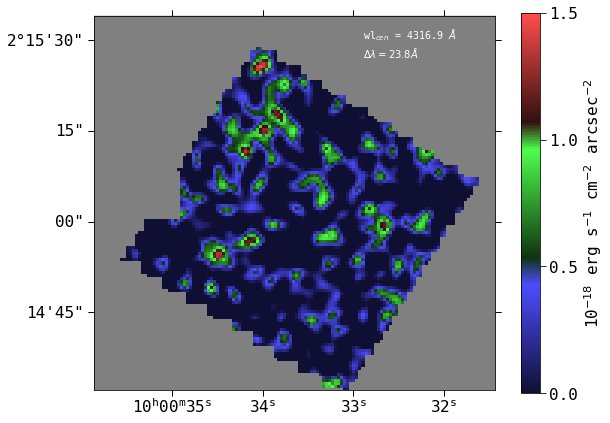

In [169]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "084"
    irange = [408,420]
    vmin=0.
    vmax=1.5
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.5
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB, irange=irange)

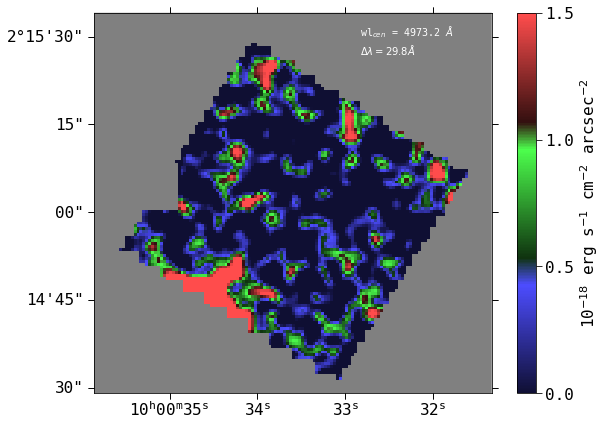

In [173]:
if RUN_AS_NOTEBOOK:

    field, ifu = "COSMOSD", "084"
    irange = [737,752]
    vmin=0.
    vmax=1.5
    CSUB = 3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    sigma=1.5
    A_pix = 0.5**2.

    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, sigma = sigma, \
                  A_pix = A_pix, CSUB=CSUB, irange=irange)